## Transfer Learning mobilenet using Keras

In [1]:
# import the libraries as shown below

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.resnet50 import ResNet50
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.Xception import Xception
#from keras.applications.MobileNetV2 import MobileNetV2
#from keras.applications.vgg16 import VGG16

from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
from matplotlib import pyplot
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [4]:


train_path = '/content/drive/MyDrive/Dataset/chest_xray/train'
valid_path = '/content/drive/MyDrive/Dataset/chest_xray/test'


In [5]:
# Import the mobilenet library as shown below and add preprocessing layer to the front of mobilenet
# Here we will be using imagenet weights
mobilenet = MobileNet(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


17235968/17225924 [==============================] - 0s 0us/step


In [6]:
# don't train existing weights
for layer in mobilenet.layers:
    layer.trainable = False

In [7]:
  # useful for getting number of output classes
folders = glob('/content/drive/MyDrive/Dataset/chest_xray/train/*')

In [8]:
# our layers - you can add more if you want
x = Flatten()(mobilenet.output)

In [9]:
prediction = Dense(1, activation='sigmoid')(x)  #len(folders) 
# create a model object
model = Model(inputs=mobilenet.input, outputs=prediction)

In [10]:

# view the structure of the model
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [11]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [12]:
# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

In [13]:

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Dataset/chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 5302 images belonging to 2 classes.


In [15]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Dataset/chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 654 images belonging to 2 classes.


In [16]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
166/166 [==============================] - 758s 4s/step - loss: 0.4750 - accuracy: 0.9353 - val_loss: 2.4641 - val_accuracy: 0.7997
Epoch 2/10
166/166 [==============================] - 145s 874ms/step - loss: 0.2197 - accuracy: 0.9645 - val_loss: 0.6823 - val_accuracy: 0.9128
Epoch 3/10
166/166 [==============================] - 145s 872ms/step - loss: 0.3264 - accuracy: 0.9619 - val_loss: 1.0523 - val_accuracy: 0.9052
Epoch 4/10
166/166 [==============================] - 143s 863ms/step - loss: 0.1955 - accuracy: 0.9764 - val_loss: 2.1669 - val_accuracy: 0.8624
Epoch 5/10
166/166 [==============================] - 145s 871ms/step - loss: 0.2160 - accuracy: 0.9747 - val_loss: 1.0068 - val_accuracy: 0.9098
Epoch 6/10
166/166 [==============================] - 142s 857ms/step - loss: 0.1688 - accuracy: 0.9776 - val_loss: 2.5618 - val_accuracy: 0.8517
Epoch 7/10
166/166 [==============================] - 144s 870ms/step - loss: 0.1989 - accuracy: 0.9762 - val_loss: 1.3645 - va

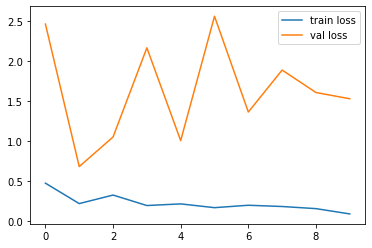

<Figure size 432x288 with 0 Axes>

In [36]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')


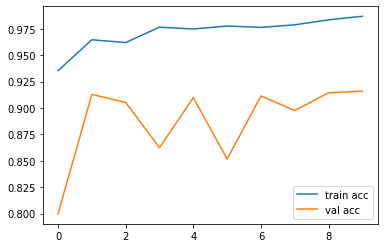

<Figure size 432x288 with 0 Axes>

In [37]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [38]:
import os,cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_actual=[]
y_test=[]

In [20]:
from re import I
from PIL.Image import NORMAL
test_data=[]
test_labels=[]
for i in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir('/content/drive/MyDrive/Dataset/chest_xray/test/' +i)):
        img=plt.imread('/content/drive/MyDrive/Dataset/chest_xray/test/'+ i+img)
        img= cv2.resize(img, (224,224))
        img= np.dstack([img, img,img])
        img=img.astype('float32')/ 255
        if i=='/NORMAL/':
          label=0
        elif i=='/PNEUMONIA/':
          label=1
        test_data.append(img)
        test_labels.append(label)

In [39]:
test_data=np.array(test_data)
test_labels=np.array(test_labels)

In [40]:
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
preds= model.predict(test_data)
acc= accuracy_score(test_labels,np.round(preds))*100
cm=confusion_matrix(test_labels,np.round(preds))
tp, fp,fn,tn= cm.ravel()
print("confusion_matrix===========")
print(cm)
print("\ntest_matrix==============")
precision=tp/(tp+fp)*100
recall=tp/(tp+fn)*100
sensitivity=tn/(tn+fp)
print('accuracy: {}%'.format(acc))
print('precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-scor: {}%'.format(2*precision*recall/(precision+recall)))

print('\n train matrix===========')
print('train acc:{}'.format(np.round((r.history['accuracy'][-1])*100,2)))


confusion_matrix===========
[[191  51]
 [  7 405]]

test_matrix==============
accuracy: 91.13149847094802%
precision: 78.92561983471074%
Recall: 96.46464646464646%
F1-scor: 86.81818181818181%

 train matrix===========
train acc:98.68


In [41]:
print(classification_report(test_labels,np.round(preds),target_names=['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.96      0.79      0.87       242
   Pneumonia       0.89      0.98      0.93       412

    accuracy                           0.91       654
   macro avg       0.93      0.89      0.90       654
weighted avg       0.92      0.91      0.91       654



<Figure size 432x288 with 0 Axes>

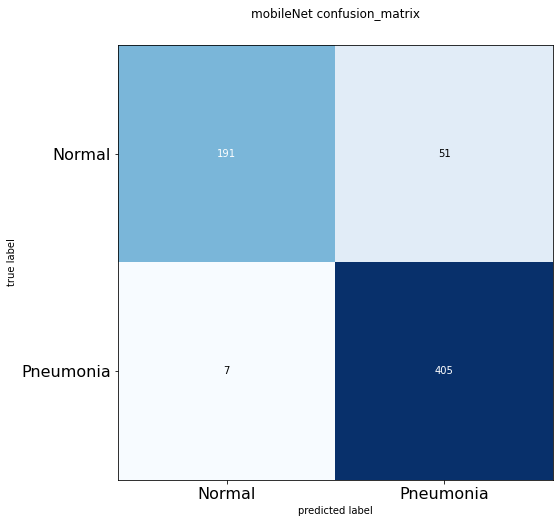

In [24]:
from mlxtend.plotting import plot_confusion_matrix
plt.figure()

plot_confusion_matrix(cm, figsize=(12,8),hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2),['Normal','Pneumonia'],fontsize=16)
plt.yticks(range(2),['Normal','Pneumonia'],fontsize=16)
plt.title("mobileNet confusion_matrix")

plt.show()


In [42]:
# save it as a h5 file

import tensorflow as tf

from keras.models import load_model

model.save('model_mobileNet.h5')

In [26]:
from keras.models import load_model

In [27]:
from keras.preprocessing import image


In [48]:
#test_set.class_indices
training_set.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [28]:
model=load_model('model_mobileNet.h5')

In [29]:
img=image.load_img('/content/drive/MyDrive/Dataset/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg',target_size=(224,224))


In [30]:
x=image.img_to_array(img)

In [31]:
x=np.expand_dims(x, axis=0)

In [32]:
img_data=preprocess_input(x)

In [33]:
classes=model.predict(img_data)

In [34]:
result=int(classes[0][0])

In [43]:
if result==1:
    print("Person is Affected By PNEUMONIA")
else:
    print("Result is Normal")

Person is Affected By PNEUMONIA
